In [1]:
#Add libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
%matplotlib inline

In [146]:
#Load data processed on the HPC

prs = pd.read_csv("../data/protein_prs_cases.csv", sep="\t", index_col=0)

prs.head()

,Group,Case,Sex,C4A.C4B.4481.34.2,IL10.2773.50.2,MMP9.2579.17.5,CSF3.8952.65.3,GC.6581.50.3,APOB.2797.56.2,CFH.4159.130.1,...,C3.2755.8.2,PPY.4588.1.2,IGFBP2.2570.72.5,APOE.2937.10.2,FGA.FGB.FGG.4907.56.1,PLG.3710.49.2,TNF.5936.53.3,ANGPT2.13660.76.3,CRP.4337.49.2,VCAM1.2967.8.1
0,A,2,2,-0.069435,-0.034924,-0.126787,0.351996,0.314848,-0.318171,0.195647,...,0.057947,0.749855,0.146249,-0.133883,-2.490502,-0.324963,-0.978661,0.039893,-0.266216,-0.038887
1,A,2,2,-1.071661,-0.421213,-0.872182,0.101832,-0.296282,0.689710,-0.409555,...,-0.903393,0.306309,-1.152134,0.421410,0.405951,0.950770,1.549364,1.410669,-1.659654,2.214628
2,A,2,1,0.321382,-2.000421,-0.126787,0.207792,0.952631,-2.252077,-1.264962,...,1.754089,1.248028,1.187176,-1.003851,-0.848056,-0.324963,-1.076009,0.381713,-0.420168,-0.413070
3,A,2,2,0.575056,-0.256073,0.618608,-1.863235,-0.379302,0.689710,-0.636036,...,-1.259195,-0.329593,-0.662532,-0.133883,1.754016,0.614542,-1.708552,-1.134225,-1.053209,-0.110263
4,A,2,2,1.512781,0.417969,-0.126787,0.091216,-0.337681,-0.318171,-0.115083,...,0.554612,-0.582945,0.512406,0.843965,0.379672,-1.239034,0.858960,-0.683777,-0.344878,-0.487496


In [147]:
#Update case and sex from 2/1 and to dummy variables 1/0
#Case -> 1 = "AD", 0 = "CTL"
#Sex -> 1 = "Female", 0 = "Male"

if (prs["Case"].max() == 2) | (prs["Sex"].max() == 2):
    prs.loc[prs["Case"] == 1, "Case"] = 0
    prs.loc[prs["Case"] == 2, "Case"] = 1

    prs.loc[prs["Sex"] == 1, "Sex"] = 0
    prs.loc[prs["Sex"] == 2, "Sex"] = 1
else:
    print("Already updated")

print(prs[["Case", "Sex"]].describe())

print(prs.groupby("Group")["Case"].sum())

              Case          Sex
count  6244.000000  6244.000000
mean      0.686579     0.598334
std       0.463921     0.490274
min       0.000000     0.000000
25%       0.000000     0.000000
50%       1.000000     1.000000
75%       1.000000     1.000000
max       1.000000     1.000000
Group
A    3277
B     639
C     371
Name: Case, dtype: int64


In [ ]:
#GOAL - predict AD status from 31 proteins using a simple feed forward neural network

#Questions
#-> how represent the input proteins e.g. float vector of 31 values? What dimensions?
#-> how represent the output of AD disease status e.g. a 2 node output layer connected by a softmax / sigmoid function? 
#-> how structure hidden layers? How many?
#-> how initialise layers?
#-> what objective, loss function?
#-> how setup batch sizes for training? e.g. all samples in one batch, randomised sub-samples, 1 sample at a time?
    #-> are batches all calculated at once? e.g. [10, 31] input if batch of 10
#-> when do you need to explicitly set a model to train? (varied across examples, not in RNN, is in CNN images)
#-> does calculating the accuracy and other metrics during training impact gradient calcs if don't set no_grad?
#-> what is best practice for measuring accuracy on test data? Average across batches?

#Resources
#-> binary classifier gist - https://gist.github.com/santi-pdp/d0e9002afe74db04aa5bbff6d076e8fe
#-> binary cross entropy loss - https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a 
#-> practical stack overflow example - https://stackoverflow.com/questions/62413462/why-is-a-simple-binary-classification-failing-in-a-feedforward-neural-network
#-> microsoft binary classifier example (+ code) - https://visualstudiomagazine.com/articles/2020/10/14/pytorch-define-network.aspx
#-> more detailed analytics vidya example - https://www.analyticsvidhya.com/blog/2019/01/guide-pytorch-neural-networks-case-studies/
#-> MNIST examples - https://adventuresinmachinelearning.com/pytorch-tutorial-deep-learning/ 
    #->+ https://www.kdnuggets.com/2018/02/simple-starter-guide-build-neural-network.html
    #->+ https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/01-basics/feedforward_neural_network/main.py
    #->+ Highly detailed and some useful code snippets - https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_feedforward_neuralnetwork/
#-> Titanic example (using Softmax) - https://www.kaggle.com/tauseef6462/simple-feedforward-neural-network-using-pytorch 
#-> other shorter examples - https://medium.com/biaslyai/pytorch-introduction-to-neural-network-feedforward-neural-network-model-e7231cff47cb
    #->+ https://medium.com/@niranjankumarc/building-a-feedforward-neural-network-using-pytorch-nn-module-52b1d7ea5c3e
#-> dataloaders - https://towardsdatascience.com/pytorch-basics-intro-to-dataloaders-and-loss-functions-868e86450047 


#Findings
    #->Mean AUC is 0.54 on test data, 0.57 on training, without tuning hyperparameters - comparable to random forest
    #->Class imbalance with significantly more cases than controls (~70:30) requires correction to improve prediction

In [4]:
#get data into train and test splits and convert to numpy
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(prs.iloc[:, 3:len(prs)].to_numpy(), prs["Case"].to_numpy(), test_size=0.25, random_state=0)

# print(x_train.shape, x_train[0:5])
# print(y_train.shape, y_train[0:5])

In [5]:
#convert numpy array to torch tensors
x_train, y_train, x_test, y_test = map(torch.tensor, (x_train, y_train, x_test, y_test))

In [6]:
print(x_train.size(), x_train[0:2])
print(y_train.size(), y_train[0:2])

torch.Size([4683, 31]) tensor([[ 1.7982e+00,  1.3856e+00, -1.2679e-01, -2.6436e-01, -6.6459e-01,
         -3.1817e-01,  2.9765e+00, -9.4479e-01,  2.0746e+00, -1.5596e-02,
          1.9561e+00, -7.3328e-01, -2.5517e-01, -2.4023e-01,  2.3657e+00,
         -2.5215e+00,  1.2740e-01, -3.1030e-02,  1.2908e-01,  2.1609e-01,
         -4.6585e-01, -9.5184e-01,  8.3606e-01,  5.8231e-01,  4.2141e-01,
         -1.0343e+00, -2.0849e+00,  2.0934e+00, -7.4518e-01,  9.4330e-01,
         -4.1696e-01],
        [-1.1928e-01, -8.6688e-01, -1.2679e-01, -4.3962e-01,  6.8738e-02,
         -1.2442e+00,  1.5526e+00, -3.1274e-03, -4.7507e-01, -1.2216e+00,
         -1.2772e-02,  1.4791e+00,  1.0703e-01, -3.3102e-01,  5.1689e-01,
          1.8115e-01, -8.5239e-01,  5.8039e-01,  5.9135e-01,  6.5476e-01,
          1.5217e+00,  1.2155e+00,  9.0697e-01,  8.1719e-01, -3.3847e+00,
          6.5582e-01, -1.7157e+00, -1.9855e+00, -3.6088e-02, -1.0532e+00,
          1.5110e-01]], dtype=torch.float64)
torch.Size([4683]) te

In [7]:
#setup torch datasets to load into dataloaders

class CustomDataset(torch.utils.data.Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    
training_data = CustomDataset(x_train, y_train)
test_data = CustomDataset(x_test, y_test)

In [110]:
#setup dataloaders to handle batches

batch_size = 150
n_iters = 10000
num_epochs = n_iters / (len(x_train) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=training_data, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_data, 
                                           batch_size=batch_size, 
                                           shuffle=False)

print(num_epochs)

320


In [100]:
#is this the best way to classify outputs to 1 or 0

def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(y_pred)

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    
    return acc

In [106]:
#Create a 1-hidden layer neural net (31 -> 50 -> 1) with a SGD optimiser and a BCE Loss objective function

class Net(nn.Module):
    #initializing layers as per Microsoft article (but does not seem to be a requirement)
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(31, 50)
        self.relu1 = nn.ReLU()
        self.out = nn.Linear(50, 1)
        self.out_act = nn.Sigmoid()
        
        torch.nn.init.xavier_uniform_(self.fc1.weight) 
        torch.nn.init.zeros_(self.fc1.bias)
        torch.nn.init.xavier_uniform_(self.out.weight) 
        torch.nn.init.zeros_(self.out.bias)
        
    def forward(self, input):
        a1 = self.fc1(input)
        h1 = self.relu1(a1)
        a2 = self.out(h1)
        y = self.out_act(a2)
        return y
    
net = Net()
opt = optim.SGD(net.parameters(), lr=0.01)
criterion = nn.BCELoss()

In [86]:
from sklearn.metrics import roc_auc_score, confusion_matrix

def confusion_metrics(y_pred, y_true):
    auc = roc_auc_score(y_true.detach().numpy(), y_pred.view(-1).detach().numpy().round())
    
    tn, fp, fn, tp = confusion_matrix(y_true.detach().numpy(), y_pred.view(-1).detach().numpy().round()).ravel()
    sensitivity = tp / (tp + fn) #-> also recall
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)
    
    return auc, sensitivity, specificity, precision


In [107]:
#Training

#turn training on 
net.train()

#track loss
losses = []
aucs= []

#loop through epochs
for e in range(1,num_epochs+1):
    
    #setup evaluation metrics
    epoch_loss = 0
    epoch_acc = 0
    epoch_auc = 0
    epoch_sens = 0
    epoch_spec = 0
    epoch_prec = 0
    
    #loop through batches
    for batch_index, batch in enumerate(train_loader):
        X_batch = batch[0].float()
        y_batch = batch[1].float()
        #zero the gradient
        opt.zero_grad()
        
        #predict the output
        y_batch_pred = net(X_batch)
        
        #calculate the loss (check expected function dimensions)
        loss = criterion(y_batch_pred, y_batch.unsqueeze(1))
        
        #calculate the accuracy
        acc = binary_acc(y_batch_pred, y_batch.unsqueeze(1))
        
        #calculate auc, sensitivity, specificity and precision
        auc, sens, spec, prec = confusion_metrics(y_batch_pred, y_batch)
        
        #compute the gradient
        loss.backward()
        
        #update the weights
        opt.step()
        
        #accumulate losses
        losses.append(loss.item())
        aucs.append(auc)
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        epoch_auc += auc
        epoch_sens += sens
        epoch_spec += spec
        epoch_prec += prec
    
    #present epoch outputs
    print("Epoch: " + str(e) + " | Loss: " + str(round(epoch_loss / len(train_loader), 3)) \
          + " | Accuracy: " + str(round(epoch_acc / len(train_loader), 3)) \
        + " | AUC: " + str(round(auc,3)) \
         + " | Sensitivity: " + str(round(sens,3)) \
         + " | Specificity: " + str(round(spec,3)) \
         + " | Precision: " + str(round(prec,3)) 
         )

#Next steps 
    #-> build evaluation to test accuracy of predictions
    #-> review if setup correct / how to add improvements


Epoch: 1 | Loss: 0.728 | Accuracy: 0.529 | AUC: 0.522 | Sensitivity: 0.793 | Specificity: 0.25 | Precision: 0.885
Epoch: 2 | Loss: 0.682 | Accuracy: 0.598 | AUC: 0.606 | Sensitivity: 0.75 | Specificity: 0.462 | Precision: 0.682
Epoch: 3 | Loss: 0.664 | Accuracy: 0.628 | AUC: 0.405 | Sensitivity: 0.81 | Specificity: 0.0 | Precision: 0.586
Epoch: 4 | Loss: 0.655 | Accuracy: 0.642 | AUC: 0.446 | Sensitivity: 0.81 | Specificity: 0.083 | Precision: 0.607
Epoch: 5 | Loss: 0.643 | Accuracy: 0.648 | AUC: 0.455 | Sensitivity: 0.818 | Specificity: 0.091 | Precision: 0.643
Epoch: 6 | Loss: 0.64 | Accuracy: 0.66 | AUC: 0.455 | Sensitivity: 0.909 | Specificity: 0.0 | Precision: 0.645
Epoch: 7 | Loss: 0.634 | Accuracy: 0.666 | AUC: 0.565 | Sensitivity: 0.9 | Specificity: 0.231 | Precision: 0.643
Epoch: 8 | Loss: 0.628 | Accuracy: 0.675 | AUC: 0.481 | Sensitivity: 0.963 | Specificity: 0.0 | Precision: 0.812
Epoch: 9 | Loss: 0.627 | Accuracy: 0.673 | AUC: 0.523 | Sensitivity: 0.955 | Specificity: 0.09

Epoch: 73 | Loss: 0.584 | Accuracy: 0.689 | AUC: 0.45 | Sensitivity: 0.833 | Specificity: 0.067 | Precision: 0.517
Epoch: 74 | Loss: 0.583 | Accuracy: 0.692 | AUC: 0.509 | Sensitivity: 0.947 | Specificity: 0.071 | Precision: 0.581
Epoch: 75 | Loss: 0.581 | Accuracy: 0.695 | AUC: 0.479 | Sensitivity: 0.958 | Specificity: 0.0 | Precision: 0.719
Epoch: 76 | Loss: 0.581 | Accuracy: 0.694 | AUC: 0.601 | Sensitivity: 0.952 | Specificity: 0.25 | Precision: 0.69
Epoch: 77 | Loss: 0.582 | Accuracy: 0.69 | AUC: 0.452 | Sensitivity: 0.75 | Specificity: 0.154 | Precision: 0.577
Epoch: 78 | Loss: 0.581 | Accuracy: 0.694 | AUC: 0.523 | Sensitivity: 0.955 | Specificity: 0.091 | Precision: 0.677
Epoch: 79 | Loss: 0.579 | Accuracy: 0.697 | AUC: 0.65 | Sensitivity: 1.0 | Specificity: 0.3 | Precision: 0.767
Epoch: 80 | Loss: 0.577 | Accuracy: 0.697 | AUC: 0.611 | Sensitivity: 1.0 | Specificity: 0.222 | Precision: 0.774
Epoch: 81 | Loss: 0.579 | Accuracy: 0.694 | AUC: 0.557 | Sensitivity: 0.913 | Specific

Epoch: 146 | Loss: 0.568 | Accuracy: 0.701 | AUC: 0.477 | Sensitivity: 0.955 | Specificity: 0.0 | Precision: 0.656
Epoch: 147 | Loss: 0.566 | Accuracy: 0.704 | AUC: 0.6 | Sensitivity: 1.0 | Specificity: 0.2 | Precision: 0.742
Epoch: 148 | Loss: 0.569 | Accuracy: 0.702 | AUC: 0.514 | Sensitivity: 0.917 | Specificity: 0.111 | Precision: 0.733
Epoch: 149 | Loss: 0.564 | Accuracy: 0.706 | AUC: 0.714 | Sensitivity: 1.0 | Specificity: 0.429 | Precision: 0.867
Epoch: 150 | Loss: 0.567 | Accuracy: 0.702 | AUC: 0.457 | Sensitivity: 0.913 | Specificity: 0.0 | Precision: 0.677
Epoch: 151 | Loss: 0.568 | Accuracy: 0.702 | AUC: 0.643 | Sensitivity: 1.0 | Specificity: 0.286 | Precision: 0.655
Epoch: 152 | Loss: 0.565 | Accuracy: 0.703 | AUC: 0.591 | Sensitivity: 1.0 | Specificity: 0.182 | Precision: 0.71
Epoch: 153 | Loss: 0.565 | Accuracy: 0.704 | AUC: 0.628 | Sensitivity: 0.957 | Specificity: 0.3 | Precision: 0.759
Epoch: 154 | Loss: 0.566 | Accuracy: 0.702 | AUC: 0.577 | Sensitivity: 0.905 | Spec

Epoch: 219 | Loss: 0.557 | Accuracy: 0.711 | AUC: 0.48 | Sensitivity: 0.96 | Specificity: 0.0 | Precision: 0.75
Epoch: 220 | Loss: 0.554 | Accuracy: 0.711 | AUC: 0.585 | Sensitivity: 0.92 | Specificity: 0.25 | Precision: 0.793
Epoch: 221 | Loss: 0.556 | Accuracy: 0.709 | AUC: 0.545 | Sensitivity: 0.909 | Specificity: 0.182 | Precision: 0.69
Epoch: 222 | Loss: 0.556 | Accuracy: 0.71 | AUC: 0.601 | Sensitivity: 0.952 | Specificity: 0.25 | Precision: 0.69
Epoch: 223 | Loss: 0.556 | Accuracy: 0.709 | AUC: 0.5 | Sensitivity: 0.909 | Specificity: 0.091 | Precision: 0.667
Epoch: 224 | Loss: 0.557 | Accuracy: 0.708 | AUC: 0.581 | Sensitivity: 0.947 | Specificity: 0.214 | Precision: 0.621
Epoch: 225 | Loss: 0.554 | Accuracy: 0.712 | AUC: 0.569 | Sensitivity: 0.917 | Specificity: 0.222 | Precision: 0.759
Epoch: 226 | Loss: 0.555 | Accuracy: 0.711 | AUC: 0.583 | Sensitivity: 0.833 | Specificity: 0.333 | Precision: 0.769
Epoch: 227 | Loss: 0.552 | Accuracy: 0.713 | AUC: 0.605 | Sensitivity: 0.96 |

Epoch: 292 | Loss: 0.545 | Accuracy: 0.719 | AUC: 0.648 | Sensitivity: 0.92 | Specificity: 0.375 | Precision: 0.821
Epoch: 293 | Loss: 0.546 | Accuracy: 0.718 | AUC: 0.563 | Sensitivity: 0.826 | Specificity: 0.3 | Precision: 0.731
Epoch: 294 | Loss: 0.546 | Accuracy: 0.719 | AUC: 0.625 | Sensitivity: 1.0 | Specificity: 0.25 | Precision: 0.7
Epoch: 295 | Loss: 0.546 | Accuracy: 0.717 | AUC: 0.442 | Sensitivity: 0.76 | Specificity: 0.125 | Precision: 0.731
Epoch: 296 | Loss: 0.547 | Accuracy: 0.717 | AUC: 0.513 | Sensitivity: 0.95 | Specificity: 0.077 | Precision: 0.613
Epoch: 297 | Loss: 0.546 | Accuracy: 0.717 | AUC: 0.56 | Sensitivity: 0.952 | Specificity: 0.167 | Precision: 0.667
Epoch: 298 | Loss: 0.547 | Accuracy: 0.718 | AUC: 0.56 | Sensitivity: 0.952 | Specificity: 0.167 | Precision: 0.667
Epoch: 299 | Loss: 0.544 | Accuracy: 0.721 | AUC: 0.546 | Sensitivity: 0.893 | Specificity: 0.2 | Precision: 0.862
Epoch: 300 | Loss: 0.543 | Accuracy: 0.724 | AUC: 0.688 | Sensitivity: 1.0 | S

0.5666184642121345


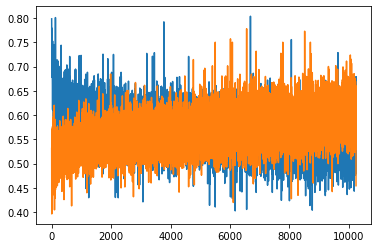

In [144]:
#consider adding smoothing
print(plt.plot(losses))

print(plt.plot(aucs))

print(np.mean(aucs))

In [138]:
def evaluate_random_prs(prs, label):
    net.eval()
    with torch.no_grad():
        output = net(prs)
        output = torch.round(output)
        print("Pred > ", output.item())
        print("Label = ", label.item())

In [139]:
for i in range(0, 20):
    prs = x_train[i].float()
    label = y_train[i].float()
    evaluate_random_prs(prs, label)

Pred >  1.0
Label =  1.0
Pred >  1.0
Label =  1.0
Pred >  1.0
Label =  1.0
Pred >  1.0
Label =  0.0
Pred >  1.0
Label =  1.0
Pred >  1.0
Label =  1.0
Pred >  1.0
Label =  1.0
Pred >  1.0
Label =  0.0
Pred >  1.0
Label =  1.0
Pred >  1.0
Label =  1.0
Pred >  1.0
Label =  0.0
Pred >  1.0
Label =  1.0
Pred >  0.0
Label =  0.0
Pred >  1.0
Label =  1.0
Pred >  1.0
Label =  0.0
Pred >  0.0
Label =  0.0
Pred >  0.0
Label =  0.0
Pred >  1.0
Label =  0.0
Pred >  1.0
Label =  1.0
Pred >  1.0
Label =  1.0


In [141]:
#full test set evaluation

test_acc = []
test_auc = []
test_sens = []
test_spec = []
test_prec = []

net.eval()
with torch.no_grad():
    for batch_index, batch in enumerate(test_loader):
        X_batch = batch[0].float()
        y_batch = batch[1].float()

        #predict the output
        y_batch_pred = net(X_batch)

        #calculate the accuracy
        acc = binary_acc(y_batch_pred, y_batch.unsqueeze(1))

        #calculate auc, sensitivity, specificity and precision
        auc, sens, spec, prec = confusion_metrics(y_batch_pred, y_batch)

        test_acc.append(acc.item())
        test_auc.append(auc)
        test_sens.append(sens)
        test_spec.append(spec)
        test_prec.append(prec)

        #present batch outputs
        print("Batch: " + str(batch_index) \
              + " | Accuracy: " + str(round(acc.item(), 3)) \
              + " | AUC: " + str(round(auc,3)) \
              + " | Sensitivity: " + str(round(sens,3)) \
              + " | Specificity: " + str(round(spec,3)) \
              + " | Precision: " + str(round(prec,3)) 
             )

Batch: 0 | Accuracy: 0.64 | AUC: 0.53 | Sensitivity: 0.825 | Specificity: 0.234 | Precision: 0.702
Batch: 1 | Accuracy: 0.66 | AUC: 0.529 | Sensitivity: 0.892 | Specificity: 0.167 | Precision: 0.695
Batch: 2 | Accuracy: 0.673 | AUC: 0.534 | Sensitivity: 0.922 | Specificity: 0.146 | Precision: 0.696
Batch: 3 | Accuracy: 0.62 | AUC: 0.503 | Sensitivity: 0.869 | Specificity: 0.137 | Precision: 0.662
Batch: 4 | Accuracy: 0.68 | AUC: 0.533 | Sensitivity: 0.941 | Specificity: 0.125 | Precision: 0.696
Batch: 5 | Accuracy: 0.68 | AUC: 0.57 | Sensitivity: 0.9 | Specificity: 0.24 | Precision: 0.703
Batch: 6 | Accuracy: 0.673 | AUC: 0.531 | Sensitivity: 0.836 | Specificity: 0.225 | Precision: 0.748
Batch: 7 | Accuracy: 0.62 | AUC: 0.528 | Sensitivity: 0.874 | Specificity: 0.182 | Precision: 0.648
Batch: 8 | Accuracy: 0.707 | AUC: 0.534 | Sensitivity: 0.926 | Specificity: 0.143 | Precision: 0.735
Batch: 9 | Accuracy: 0.707 | AUC: 0.572 | Sensitivity: 0.888 | Specificity: 0.256 | Precision: 0.748
B

In [143]:
print("Mean accuracy: ", np.mean(test_acc))
print("Mean auc: ", np.mean(test_auc))
print("Mean sensitivity: ", np.mean(test_sens))
print("Mean specificity: ", np.mean(test_spec))
print("Mean precision: ", np.mean(test_prec))

Mean accuracy:  0.6695380048318342
Mean auc:  0.5393654666227389
Mean sensitivity:  0.8910206560540737
Mean specificity:  0.187710277191404
Mean precision:  0.7050636886134058
